In [1]:
## Desenvolvido por:    Jhordan Silveira de Borba
## E-mail:              jhordandecacapava@gmail.com
## Website:             https://github.com/SapoGitHub
##                      https://alkasl.wordpress.com   
## 2019

from qiskit import *                             # Importamos as principais funções do Qiskit
from qiskit.visualization import plot_histogram  # A função para plotar o histograma
from qiskit.tools.monitor import job_monitor     # A função pra monitorar o trabalho
IBMQ.load_account()                              # Carregamos nossa conta
provider = IBMQ.get_provider(group='open')       # E uma lista de provedores

* ___Porta X___: é a porta de Pauli X, correspondente a matrix X de Pauli, tem a propriedade de inverter o valor do bit.

In [2]:
# CONSTRUÇÃO

## Circuito 1
bell = QuantumCircuit(2, 2)                          # 2 Registradores quânticos e 2  clássicos
bell.h(0)                                            # Aplicamos a porta de Hadamard no bit 0
bell.cx(0, 1)                                        # O CNOT entre os bits 0 e 1

## Circuito 2                                      
meas = QuantumCircuit(2, 2)                          # 2 Registradores novamente
meas.measure([0,1], [0,1])                           # Vamos medir

# EXECUÇÃO
backend = BasicAer.get_backend('qasm_simulator')     # Escolhomos o backend
circ = bell+meas                                     # Fazemos uma composição dos sistemas
result = execute(circ, backend, shots=1000).result() # Pegamos o resultado de uma simulação rodando 1000 vezes
counts  = result.get_counts(circ)                    # Contamos os resultados
print(counts)                                        # Printamos

{'11': 490, '00': 510}


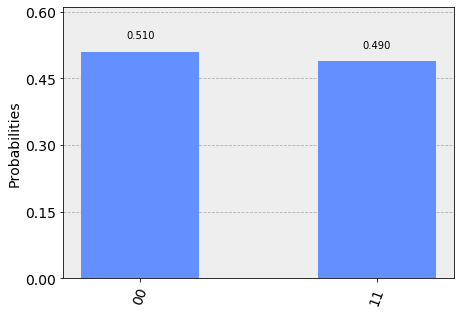

In [3]:
plot_histogram(counts)  #  Plotamos

Argumentos:
* legend: adiciona rótulos para as execuções
* sort: a ordem que as barras são renderizadas no histograma ('asc' ou 'desc')
* number_to_keep: número de termos pra exibir
* color: uma string ou lista de string com as cores para as barras de cada execução
* bar_labels: Se exibe ou não os rótulos 
* figsize: tupla com o tamanho da figura

In [4]:
#Executamos de novo
second_result = execute(circ, backend, shots=1000).result()
second_counts  = second_result.get_counts(circ)

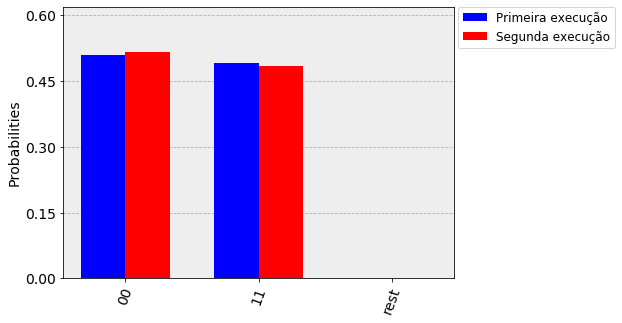

In [5]:
# Plotamos
legend = ['Primeira execução', 'Segunda execução']
cores = ['blue','red']
plot_histogram([counts, second_counts], legend=legend, sort='asc',number_to_keep=2,color=cores,bar_labels=False)

# Medindo distância do estado alvo

Se a solução de um algoritmo está contido em um único estado alvo (1011 por exemplo), quando rodamos em um dispositivo quântico real, temos alguns ruídos que podem atrapalhar a solução.  Podemos ordenar a saíde como a função de uma 'distância' do estado alvo, isso é feito com a métrica de distância de Hamming.

## Distância de Hamming

A distância de Hamming é a contagem de quantos bits são diferentes entre dois padrões. Mais genericamente, se duas listas ordenadas de items sã ocomparadas, a distância de Hamming é o número de items que não são idênticos. Em outras palavras, mede o número mínimo de substituições requeridas para transformar uma lista em outra.

Isso pode ser por exemplo, com uma operação simples de XOR ($\oplus$) bit a bit. Se temos duas listas $\left\{ j_{n}\right\} _{n=1}^{m}$ e $\left\{ i_{n}\right\} _{n=1}^{m}$ então a distância é simplesmente:

\begin{equation}
d=\sum_{n=1}^{m}j_{n}\oplus i_{n}
\end{equation}


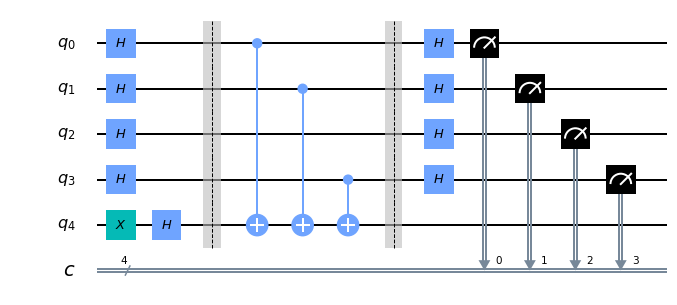

In [6]:
qc = QuantumCircuit(5, 4)             # Vamos criar um novo circuito
qc.x(4)
for idx in range(5):                  # Vamos aplicar a porta de Hadamard em todos os bits
    qc.h(idx)                         # Aplicamos a porta X
qc.barrier()                          # Colocamos a barreira visual
qc.cx(0, 4)                           # Um not-controlado entre o bit 0 e 4
qc.cx(1, 4)                           # Um not-controlado entre o bit 1 e 4
qc.cx(3, 4)                           # Um not-controlado entre o bit 3 e 4
qc.barrier()                          # Outra barreira

for idx in range(4):                  # Aplicamos a porta de Hadamard nos primeiros quatro bits
    qc.h(idx)
qc.measure([0,1,2,3], [0,1,2,3])      # E medimos os 4 primeiros bits
qc.draw()                             # Desenhamos tela

Agora o nosso estado composto vai ser dado por:
\begin{equation}
\Psi=q\left[5\right]\otimes q\left[4\right]\otimes q\left[3\right]\otimes q\left[2\right]\otimes q\left[1\right]\otimes q\left[0\right]
\end{equation}

Isso vai dar $2^{5}$ possíveis estados, então nosso vetor de estados vai ter dimensão $n=32$. Por isso fica complicado para calcularmos a mão, portanto vamos começar a utilizar o Python. Vamos definir uma função pra fazer composição de matrizes:

In [7]:
import numpy as np       # Biblioteca de computação científica

# Vamos fazer a composição de strings C=AxB
def compose_string(A,B):
    # A  Matriz
    # B  Matriz
    
    # Primeiro precisamos analizar as dimensões
    # Matriz A
    linA=len(A[:,0]) # Tamanho da coluna de A (quantidade de linhas)
    colA=len(A[0])   # Tamanho da Linha de A  (quantidade de colunas)

    # Matriz B
    linB=len(B[:,0]) 
    colB=len(B[0])   # Linha de B

    col=colA*colB    # Dimensão da coluna
    lin=linA*linB    # Dimensão da linha

    C=np.empty([lin, col],dtype='<U7') # Criamos nossa matriz de string

    m=n=0            # Endereços da nossa matriz resultante

    for x in range (linA):      # Vamos percorrer a linha da matriz A
        M=x*linB                # A cada troca de linhas vamos pular a dimensão da matriz B
        for y in range (colA) : # E a coluna de A
            N=y*colB            # A cada troca de coluna de A, vamos pular a dimensão de B       
            #Então vamos multiplicar por todos elementos de B
            m=M                 # Resetamos a linha
            for j in range (linB):
                n=N             # Resetamos a coluna           
                for l in range (colB):
                    elemento=A[x][y]+B[j][l]
                    C[m][n]=elemento
                    n=n+1
                m=m+1
    return(C)

Nossa base vai ser então:

In [23]:
#Nossa lista de bases de cada bit
bb=[np.array([['0'],['1']]),np.array([['0'],['1']]),np.array([['0'],['1']]),np.array([['0'],['1']]),np.array([['0'],['1']])]

be=compose_string(bb[4],bb[3]) # Entre o bit 4 e o 3
be=compose_string(be,bb[2])    # Com o bit 2
be=compose_string(be,bb[1])    # Com o bit 1
be=compose_string(be,bb[0])    # Com o bit 0
    
print(be.transpose())                      # Printamos nosso vetor de base

[['00000' '00001' '00010' '00011' '00100' '00101' '00110' '00111' '01000'
  '01001' '01010' '01011' '01100' '01101' '01110' '01111' '10000' '10001'
  '10010' '10011' '10100' '10101' '10110' '10111' '11000' '11001' '11010'
  '11011' '11100' '11101' '11110' '11111']]


E o nosso vetor de estado inicial é:

In [9]:
# Vamos fazer a composição de strings C=AxB
def compose(A,B):
    # A  Matriz
    # B  Matriz
    
    # Primeiro precisamos analizar as dimensões
    # Matriz A
    linA=len(A[:,0]) # Tamanho da coluna de A (quantidade de linhas)
    colA=len(A[0])   # Tamanho da Linha de A  (quantidade de colunas)

    # Matriz B
    linB=len(B[:,0]) 
    colB=len(B[0])   # Linha de B

    col=colA*colB    # Dimensão da coluna
    lin=linA*linB    # Dimensão da linha

    C=np.empty([lin, col]) # Criamos nossa matriz de string

    m=n=0            # Endereços da nossa matriz resultante

    for x in range (linA):      # Vamos percorrer a linha da matriz A
        M=x*linB                # A cada troca de linhas vamos pular a dimensão da matriz B
        for y in range (colA) : # E a coluna de A
            N=y*colB            # A cada troca de coluna de A, vamos pular a dimensão de B       
            #Então vamos multiplicar por todos elementos de B
            m=M                 # Resetamos a linha
            for j in range (linB):
                n=N             # Resetamos a coluna           
                for l in range (colB):
                    elemento=A[x][y]*B[j][l]
                    C[m][n]=elemento
                    n=n+1
                m=m+1
    return(C)

In [24]:
# Então o vetor de estado de cada qubit
q=[np.array([[1],[0]]),np.array([[1],[0]]),np.array([[1],[0]]),np.array([[1],[0]]),np.array([[1],[0]])]

e=compose(q[4],q[3]) # Entre o bit 4 e o 3
e=compose(e,q[2]) # Com o bit 2
e=compose(e,q[1]) # Com o bit 1
e=compose(e,q[0]) # Com o bit 0

print(e.transpose())                      # Printamos nosso vetor de estado

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
# Função para exibir os valores diferentes de 0
def dif(e):
    # e - vetor de estado
    
    val=0
    ind=[]
    for i in range(len(e)):
        if abs(e[i])==val:
            ind.append(i)
        elif abs(e[i])>val:
            val=abs(e[i])
            ind=[]
            ind.append(i)
    return ind

Então primeiro precisamos fazer o CNOT entre o bit 4 e o 0 (lembrando que o Qiskit inverte a ordem), precisamos então fazer uma matriz $16\times 16$. Então ignoramos o bit 5 e fazemos a composição do bit 4 ao 0.

Qualquer matriz de operação agora deve ser $32\otimes32$. Então pra aplicar a porta de hadamard em cada um dos primeiros qubits temos:
\begin{eqnarray}
H_{0}=\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes H \\
H_{1}=\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes H\otimes\mathbb{I}_{2\times2} \\
H_{2}=\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes H\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2} \\
H_{3}=\mathbb{I}_{2\times2}\otimes H\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2} \\
H_{4}=H\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}
\end{eqnarray}

In [12]:
h = np.array([[np.sqrt(1/2),np.sqrt(1/2)],[np.sqrt(1/2),-np.sqrt(1/2)]])    # Porta de Hadamard
I = np.array([[1,0],[0,1]])                                                 # Matriz identidade 2x2

H=[0]*5   # Nosso veetor de portas de Hadamard

#Porta 0
H[0]=compose(I,I)
H[0]=compose(H[0],I)
H[0]=compose(H[0],I)
H[0]=compose(H[0],h)

#Porta 1
H[1]=compose(I,I)
H[1]=compose(H[1],I)
H[1]=compose(H[1],h)
H[1]=compose(H[1],I)

#Porta 2
H[2]=compose(I,I)
H[2]=compose(H[2],h)
H[2]=compose(H[2],I)
H[2]=compose(H[2],I)

#Porta 3
H[3]=compose(I,h)
H[3]=compose(H[3],I)
H[3]=compose(H[3],I)
H[3]=compose(H[3],I)

#Porta 4
H[4]=compose(h,I)
H[4]=compose(H[4],I)
H[4]=compose(H[4],I)
H[4]=compose(H[4],I)

Agora preciamos fazer o mesmo com a porta X: como é no bit 4:
\begin{equation}
X_{4}=X\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}
\end{equation}

In [13]:
#Porta X
Px=np.array([[0,1],[1,0]])
X=compose(Px,I)
X=compose(X,I)
X=compose(X,I)
X=compose(X,I)

Agora preciamos cuidar das portas CNOT. vamos começar com uma matriz identidade $32\times32$. 
\begin{equation}
\mathbb{I}_{32\times32}=\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}\otimes\mathbb{I}_{2\times2}
\end{equation}

In [14]:
import copy                   # Biblioteca com função para copiar vetores e matrizes

# Identidade 32x32
I16=compose(I,I)
I16=compose(I16,I)
I16=compose(I16,I)
I16=compose(I16,I)

# Nosso vetor de matrizes CNOT
C=[0]*5

# CNOT entre o bit 0 e 4

#Se é o bit 0, precisamos alterar a cada 1 linha
x=int(32/2+1)
C[0]=copy.deepcopy(I16)
for i in range(1,int(32/2),2):
    C[0][i]=C[0][i]*0          # Zeramos a linha Atual 
    C[0][x]=C[0][x]*0          # Zeramos a linha que vai trocar
    
    C[0][i][x]=1
    C[0][x][i]=1
    
    x=x+2    


#Se é o bit 1, precisamos alterar a cada 4 linha e manter 2
C[1]=copy.deepcopy(I16)
x=int(32/2+2)
for i in range(2,int(32/2),4):
    C[1][i]=C[1][i]*0          # Zeramos a linha Atual 
    C[1][x]=C[1][x]*0          # Zeramos a linha que vai trocar
    
    C[1][i][x]=1
    C[1][x][i]=1
       
    C[1][i+1]=C[1][i+1]*0          # Zeramos a linha Atual 
    C[1][x+1]=C[1][x+1]*0          # Zeramos a linha que vai trocar
    
    C[1][i+1][x+1]=1
    C[1][x+1][i+1]=1
    
    x=x+4    
    
x=int(32/2+8)
#Se é o bit 3, precisamos alterar a cada 4 linha e manter 2
C[3]=copy.deepcopy(I16)
for i in range(8,int(32/2),16):
    C[3][i]=C[3][i]*0          # Zeramos a linha Atual 
    C[3][x]=C[3][x]*0          # Zeramos a linha que vai trocar
    
    C[3][i][x]=1
    C[3][x][i]=1
    
    C[3][i+1]=C[3][i+1]*0          # Zeramos a linha Atual 
    C[3][x+1]=C[3][x+1]*0          # Zeramos a linha que vai trocar
    
    C[3][i+1][x+1]=1
    C[3][x+1][i+1]=1

    C[3][i+2]=C[3][i+2]*0          # Zeramos a linha Atual 
    C[3][x+2]=C[3][x+2]*0          # Zeramos a linha que vai trocar
    
    C[3][i+2][x+2]=1
    C[3][x+2][i+2]=1
    
    C[3][i+3]=C[3][i+3]*0          # Zeramos a linha Atual 
    C[3][x+3]=C[3][x+3]*0          # Zeramos a linha que vai trocar
    
    C[3][i+3][x+3]=1
    C[3][x+3][i+3]=1
    
    C[3][i+4]=C[3][i+4]*0          # Zeramos a linha Atual 
    C[3][x+4]=C[3][x+4]*0          # Zeramos a linha que vai trocar
    
    C[3][i+4][x+4]=1
    C[3][x+4][i+4]=1
    
    C[3][i+5]=C[3][i+5]*0          # Zeramos a linha Atual 
    C[3][x+5]=C[3][x+5]*0          # Zeramos a linha que vai trocar
    
    C[3][i+5][x+5]=1
    C[3][x+5][i+5]=1

    C[3][i+6]=C[3][i+6]*0          # Zeramos a linha Atual 
    C[3][x+6]=C[3][x+6]*0          # Zeramos a linha que vai trocar
    
    C[3][i+6][x+6]=1
    C[3][x+6][i+6]=1
    
    C[3][i+7]=C[3][i+7]*0          # Zeramos a linha Atual 
    C[3][x+7]=C[3][x+7]*0          # Zeramos a linha que vai trocar
    
    C[3][i+7][x+7]=1
    C[3][x+7][i+7]=1
    x=x+16


Podemos então calcular a saída esperada do nosso sistema:

In [15]:
ne=H[0].dot(e)
ne=H[1].dot(ne)
ne=H[2].dot(ne)
ne=H[3].dot(ne)
ne=X.dot(ne)
ne=H[4].dot(ne)

ne=C[0].dot(ne)
ne=C[1].dot(ne)
ne=C[3].dot(ne)

ne=H[0].dot(ne)
ne=H[1].dot(ne)
ne=H[2].dot(ne)
ne=H[3].dot(ne)

print('Os possíveis estados medidos são:')
for x in (dif(ne)):
    print(be[x][0]+' - Com probabilidade de: {0:.2f}'.format((ne[x][0]*ne[x][0]))) 

Os possíveis estados medidos são:
01011 - Com probabilidade de: 0.50
11011 - Com probabilidade de: 0.50


Mas podemos fazer isso de um jeito mais inteligente:

In [16]:
# Vamos fazer uma função pra gerar o CNOT

def cnot(bit):
    # Qual bit estamo gerando o CNOT
    
    # Identidade 32x32
    I16=compose(I,I)
    I16=compose(I16,I)
    I16=compose(I16,I)
    I16=compose(I16,I)

    #Se é o bit 0, precisamos alterar a cada 1 linha
    
    x=int(32/2+np.power(2,bit))

    for i in range(np.power(2,bit),int(32/2),np.power(2,bit+1)):

        for j in range(int(np.power(2,bit+1)/2)):
            I16[i+j]=I16[i+j]*0          # Zeramos a linha Atual 
            I16[x+j]=I16[x+j]*0          # Zeramos a linha que vai trocar

            I16[i+j][x+j]=1
            I16[x+j][i+j]=1

        x=x+np.power(2,bit+1)    
    return I16

In [17]:
# Usamos nossa função pra criar os cnot

C=[0]*5
C[0]=cnot(0)
C[1]=cnot(1)
C[3]=cnot(3)

In [18]:
# Vamos criar uma matriz que representa todas nossas operações:

M=H[2].dot(H[3])
M=M.dot(H[1])
M=M.dot(H[0])

M=M.dot(C[3])
M=M.dot(C[1])
M=M.dot(C[0])

M=M.dot(H[4])
M=M.dot(X)
M=M.dot(H[3])
M=M.dot(H[2])
M=M.dot(H[1])
M=M.dot(H[0])

In [19]:
e=e*0
e[0]=1

ne=M.dot(e)

print('Os possíveis estados medidos são:')
for x in (dif(ne)):
    print(be[x][0]+' - Com probabilidade de: {0:.2f}'.format((ne[x][0]*ne[x][0]))) 

Os possíveis estados medidos são:
01011 - Com probabilidade de: 0.50
11011 - Com probabilidade de: 0.50
